# Testes do Grupo 01 para SS: Open Suturing Skill 2025

Ainda por decidir a arquitetura, mas será ou TSN,LSTM ou baseada em YOLO

# Preparação da Submissão

## Imports e seeding

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import torch.nn.functional as F
import cv2

import torchvision.transforms as transforms
from torchvision.io import read_video
import torchvision.io as tvio   
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary


from livelossplot import PlotLosses

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

## Setup

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
print(device)

cpu


## Vizualização de Dados

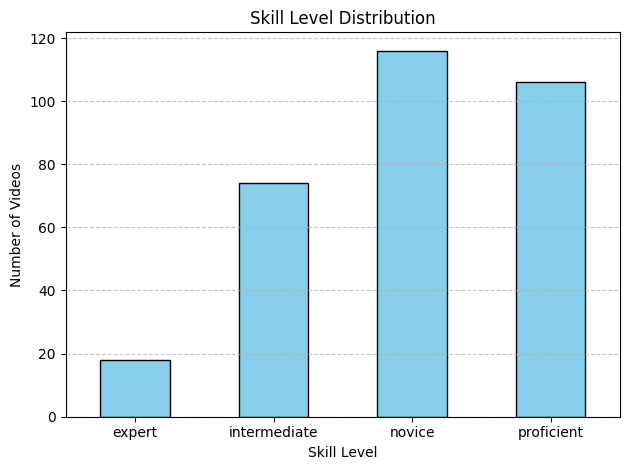

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def _load_labels(path):
    """Load labels from Excel file and map to video names"""
    df = pd.read_excel(path, header=0)

    # Drop unnecessary columns
    df = df.drop(columns=["STUDENT","GROUP","TIME","SUTURES","INVESTIGATOR"])

    # Group by video and take mean of scores
    df = df.groupby("VIDEO").mean()

    # Create skill level labels
    df["TARGET_CLASS"] = df["GLOBA_RATING_SCORE"].apply(
        lambda x: "novice" if 8 <= x < 16 else
                "intermediate" if 16 <= x < 24 else
                "proficient" if 24 <= x < 32 else
                "expert" if 32 <= x < 41 else None
    )

    return df["TARGET_CLASS"]

# Load labels from Excel
labels = _load_labels("OSATS.xlsx")

# Plotting class distribution
label_counts = labels.value_counts().sort_index()
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Skill Level Distribution")
plt.xlabel("Skill Level")
plt.ylabel("Number of Videos")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


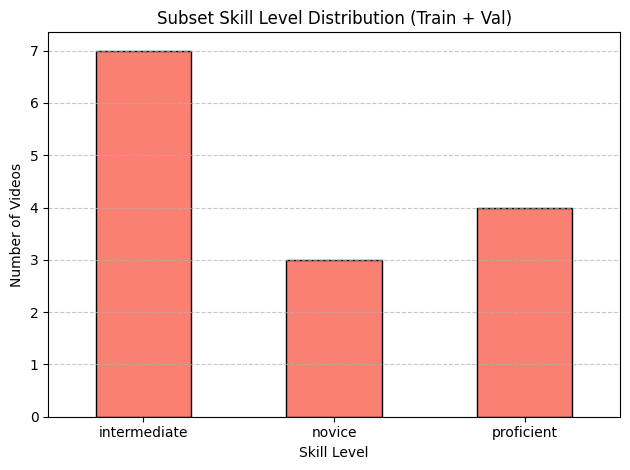

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def get_video_names_from_folders(*folders):
    """Get base video names (without extension) from folders"""
    video_names = set()
    for folder in folders:
        for fname in os.listdir(folder):
            name, _ = os.path.splitext(fname)
            video_names.add(name)
    return video_names

# Step 1: Load all labels
all_labels = _load_labels("OSATS.xlsx")

# Step 2: Get video names in folders
video_names = get_video_names_from_folders("Package_train", "Package_val")

# Step 3: Filter labels
subset_labels = all_labels[all_labels.index.isin(video_names)]

# Step 4: Plot
label_counts = subset_labels.value_counts().sort_index()
label_counts.plot(kind='bar', color='salmon', edgecolor='black')

plt.title("Subset Skill Level Distribution (Train + Val)")
plt.xlabel("Skill Level")
plt.ylabel("Number of Videos")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## CNN

In [3]:
class SegmentedVideoDataset(Dataset):
    def __init__(self, root_dir, label_path, transform=None, segments=10, frames_per_clip=16, enforce_last_segment=True,resize=(224, 224)):
        """
        Args:
            root_dir (str): Directory containing video files
            label_path (str): Path to Excel file with labels
            transform (callable, optional): Transformations for each frame
            segments (int): Number of random segments per video
            frames_per_clip (int): Frames per segment
            enforce_last_segment (bool): If True, forces one segment to be the last possible clip
        """
        self.root_dir = root_dir
        self.transform = transform
        self.segments = segments
        self.frames_per_clip = frames_per_clip
        self.enforce_last_segment = enforce_last_segment
        self.resize = resize
        
        # Get video files and labels
        self.video_files = [f for f in os.listdir(root_dir) if f.endswith(('.mp4'))]
        self.label_dict = self._load_labels(label_path)
        
    def _load_labels(self, path):
        """Load labels from Excel file and map to video names"""
        df = pd.read_excel(path, header=0)
        
        df = df.drop(columns=["STUDENT","GROUP","TIME","SUTURES","INVESTIGATOR"])

        df = df.groupby("VIDEO").mean()
        
        # Create skill level labels
        df["TARGET_CLASS"] = df["GLOBA_RATING_SCORE"].apply(
            lambda x: "novice" if 8 <= x < 16 else
                    "intermediate" if 16 <= x < 24 else
                    "proficient" if 24 <= x < 32 else
                    "expert" if 32 <= x < 41 else None
        )
        # print(df.head())
            
        return dict(zip(df.index, df["TARGET_CLASS"]))
    
    def __len__(self):
        return len(self.video_files)
    
    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.video_files[idx])
        
        # Get label
        video_name = os.path.splitext(self.video_files[idx])[0]
        label = self.label_dict.get(video_name, None)
        
        # Read video with OpenCV instead of torchvision
        frames = self._read_video_cv2(video_path)
        
        # Create a tensor from frames
        if len(frames) > 0:
            # Convert list of frames to tensor [T, C, H, W]
            video = torch.stack([torch.from_numpy(frame).permute(2, 0, 1) for frame in frames])
        else:
            # Create dummy frames if video couldn't be read
            print(f"Warning: Could not read frames from {video_path}. Creating dummy frames.")
            video = torch.zeros(self.frames_per_clip, 3, self.resize[0], self.resize[1], dtype=torch.uint8)
        
        total_frames = video.shape[0]
        
        # Pad if video is too short
        if total_frames < self.frames_per_clip:
            if total_frames == 0:
                padding = torch.zeros(self.frames_per_clip, 3, self.resize[0], self.resize[1], dtype=torch.uint8)
            else:
                padding = video[-1:].repeat(self.frames_per_clip - total_frames, 1, 1, 1)
            video = torch.cat([video, padding], dim=0)
            total_frames = video.shape[0]
        
        # Calculate possible starting indices
        max_start = max(0, total_frames - self.frames_per_clip)
        possible_starts = list(range(0, max_start + 1))
        
        # Enforce the last segment if required
        segments = []
        if self.enforce_last_segment and max_start >= 0:
            last_segment_start = max_start
            last_clip = video[last_segment_start : last_segment_start + self.frames_per_clip]
            segments.append(last_clip)
            possible_starts = [s for s in possible_starts if s != last_segment_start]
        
        # Sample remaining segments randomly
        remaining_segments = self.segments - len(segments)
        if remaining_segments > 0 and possible_starts:
            if len(possible_starts) < remaining_segments:
                random_starts = random.choices(possible_starts, k=remaining_segments)
            else:
                random_starts = random.sample(possible_starts, remaining_segments)
            
            for start in random_starts:
                clip = video[start : start + self.frames_per_clip]
                segments.append(clip)
        
        # If no segments were created, create a dummy segment
        if not segments:
            print(f"Warning: No segments created for {video_path}. Creating dummy segment.")
            segments = [torch.zeros(self.frames_per_clip, 3, self.resize[0], self.resize[1], dtype=torch.uint8)]
        
        # Apply transforms
        if self.transform:
            transformed_segments = []
            for clip in segments:
                transformed_frames = []
                for frame in clip:
                    frame = self.transform(frame)
                    transformed_frames.append(frame)
                
                transformed_segments.append(torch.stack(transformed_frames))
            segments = transformed_segments
        
        # Convert label to tensor
        label_tensor = torch.tensor(self._label_to_index(label)) if label else torch.tensor(-1)
        
        return segments, label_tensor
    
    def _read_video_cv2(self, video_path):
        """Read video frames using OpenCV"""
        frames = []
        
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video {video_path}")
                return frames
            
            # Get total frame count for debugging
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            print(f"Total frames in video {os.path.basename(video_path)}: {total_frames}")
            
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Convert BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Resize to specified dimensions ( helps with conputation cost)
                if frame.shape[0] != self.resize[0] or frame.shape[1] != self.resize[1]:
                    frame = cv2.resize(frame, (self.resize[0], self.resize[1]))
                    
                frames.append(frame)
                
            cap.release()
            
            if len(frames) == 0 and total_frames > 0:
                print(f"Warning: OpenCV reported {total_frames} frames but read 0 frames from {video_path}")
                
        except Exception as e:
            print(f"Error reading video with OpenCV: {e}")
            
        return frames
    
    def _label_to_index(self, label):
        """Convert string label to numerical index"""
        label_map = {
            "novice": 0,
            "intermediate": 1,
            "proficient": 2,
            "expert": 3
        }
        return label_map.get(label, -1)
    
    def save_clip(self, clip, output_path="transformed_clip.mp4", fps=15, mean=None, std=None):
        """
        Save a clip as a video file using OpenCV
        Args:
            clip: Tensor of shape [T, C, H, W]
            output_path: Output file path
            fps: Frames per second for the output video
            mean: Mean for normalization (optional)
            std: Standard deviation for normalization (optional)
        """
        try:
            if clip.dim() != 4:
                raise ValueError(f"Expected clip with 4 dimensions but got shape {clip.shape}")
            
            # Process the clip
            if mean is not None and std is not None:
                # Denormalize if needed
                clip = clip * std.view(3, 1, 1) + mean.view(3, 1, 1)
            
            # Convert to uint8 and proper format for OpenCV [T, H, W, C]
            clip = clip.permute(0, 2, 3, 1).cpu().numpy()
            
            # Convert to uint8 if not already
            if clip.dtype != np.uint8:
                clip = (clip * 255).astype(np.uint8)
            
            # Get dimensions
            T, H, W, C = clip.shape
            
            # Use OpenCV to write video
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID' for AVI
            out = cv2.VideoWriter(output_path, fourcc, fps, (W, H))
            
            if not out.isOpened():
                raise Exception(f"Could not open output video file {output_path}")
            
            for frame in clip:
                # Convert RGB to BGR for OpenCV
                frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                out.write(frame_bgr)
            
            out.release()
            print(f"Successfully saved clip to {output_path}")
            
            # Also save the first frame as an image for verification
            first_frame_path = os.path.splitext(output_path)[0] + "_first_frame.jpg"
            first_frame_bgr = cv2.cvtColor(clip[0], cv2.COLOR_RGB2BGR)
            cv2.imwrite(first_frame_path, first_frame_bgr)
            print(f"Saved first frame to {first_frame_path}")
            
        except Exception as e:
            print(f"Error saving clip: {e}")
            
            # Save individual frames as a fallback
            try:
                frames_dir = os.path.splitext(output_path)[0] + "_frames"
                os.makedirs(frames_dir, exist_ok=True)
                
                for i, frame in enumerate(clip):
                    frame_path = os.path.join(frames_dir, f"frame_{i:04d}.jpg")
                    # Convert RGB to BGR for OpenCV
                    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(frame_path, frame_bgr)
                
                print(f"Saved {len(clip)} individual frames to {frames_dir}")
            except Exception as frame_error:
                print(f"Error saving individual frames: {frame_error}")




def test_dataset(dataset,segment_time,fps):
    try:
        print(f"Number of videos found: {len(dataset.video_files)}")
        
        if len(dataset.video_files) > 0:
            # List all video files
            print("Video files found:")
            for i, video_file in enumerate(dataset.video_files):
                print(f"  {i+1}. {video_file}")
            
            # Process first video
            video_path = os.path.join(dataset.root_dir, dataset.video_files[0])
            print(f"\nProcessing first video: {video_path}")
            
            # Try to get data for first video
            try:
                data = dataset[0]
                if data and len(data) >= 1 and isinstance(data[0], list) and len(data[0]) > 0:
                    first_segment = data[0][0]  # First segment of first video
                    print(f"First segment shape: {first_segment.shape}")
                    dataset.save_clip(first_segment, output_path="transformed_clip.mp4", fps=fps)
                else:
                    print("No segments found in the first video")
            except Exception as e:
                print(f"Error processing first video: {e}")

    except Exception as e:
        print(f"Fatal error: {e}")

In [4]:
# segment_time = 15
# fps = 15
# data = SegmentedVideoDataset(
#             root_dir="Package",
#             label_path="OSATS.xlsx",
#             transform=transforms.Compose([
#                 transforms.ToPILImage(),
#                 transforms.Resize((244, 244)), # Most utilized size for CNNs 
#                 transforms.ToTensor(),  # No Normalize() yet!
#             ]),
#             segments=10,
#             frames_per_clip=segment_time * fps,
#             enforce_last_segment=True
#         )

# test_dataset(data,segment_time,fps)

## TSN

In [5]:
class SegmentedVideoDatasetForTSN(Dataset):
    """
    Modified dataset class for Temporal Segment Network (TSN)
    TSN samples a fixed number of segments from each video and uses a 2D CNN on individual frames
    """
    def __init__(self, root_dir, label_path, transform=None, num_segments=8, 
                 new_length=1, random_shift=True, test_mode=False, resize=(224, 224)):
        """
        Args:
            root_dir (str): Directory with video files
            label_path (str): Path to label file
            transform (callable): Transformations for frames
            num_segments (int): Number of segments to sample from each video
            new_length (int): Number of consecutive frames to sample for each segment (usually 1 for RGB)
            random_shift (bool): Use random temporal shift for training
            test_mode (bool): If True, sample center frame from each segment
        """
        self.root_dir = root_dir
        self.transform = transform
        self.num_segments = num_segments
        self.new_length = new_length
        self.random_shift = random_shift
        self.test_mode = test_mode
        self.resize = resize
        
        # Load video files and labels
        self.video_files = [f for f in os.listdir(root_dir) if f.endswith(('.mp4'))]
        self.label_dict = self._load_labels(label_path)
        
        # Compute offsets for segments
        self._compute_indices()
        
    def _load_labels(self, path):

        """Load labels from Excel file and map to video names"""
        df = pd.read_excel(path, header=0)
        
        df = df.drop(columns=["STUDENT","GROUP","TIME","SUTURES","INVESTIGATOR"])

        df = df.groupby("VIDEO").mean()
        
        # Create skill level labels
        df["TARGET_CLASS"] = df["GLOBA_RATING_SCORE"].apply(
            lambda x: "novice" if 8 <= x < 16 else
                    "intermediate" if 16 <= x < 24 else
                    "proficient" if 24 <= x < 32 else
                    "expert" if 32 <= x < 41 else None
        )
        # print(df.head())
            
        return dict(zip(df.index, df["TARGET_CLASS"]))
    
    def __len__(self):
        return len(self.video_files)
    
    def _read_video_cv2(self, video_path):
        """Read video frames using OpenCV"""
        frames = []
        
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video {video_path}")
                return frames
            
            # Get total frame count for debugging
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            print(f"Total frames in video {os.path.basename(video_path)}: {total_frames}")
            
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Convert BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Resize to specified dimensions ( helps with conputation cost)
                if frame.shape[0] != self.resize[0] or frame.shape[1] != self.resize[1]:
                    frame = cv2.resize(frame, (self.resize[0], self.resize[1]))
                    
                frames.append(frame)
                
            cap.release()
            
            if len(frames) == 0 and total_frames > 0:
                print(f"Warning: OpenCV reported {total_frames} frames but read 0 frames from {video_path}")
                
        except Exception as e:
            print(f"Error reading video with OpenCV: {e}")
            
        return frames
    
    def _label_to_index(self, label):
        """Convert string label to numerical index"""
        label_map = {
            "novice": 0,
            "intermediate": 1,
            "proficient": 2,
            "expert": 3
        }
        return label_map.get(label, -1)
    
    def _compute_indices(self):
        """
        Compute indices for each video ahead of time to speed up training
        """
        self.video_indices = {}
        for video_file in self.video_files:
            video_path = os.path.join(self.root_dir, video_file)
            try:
                cap = cv2.VideoCapture(video_path)
                if not cap.isOpened():
                    print(f"Error: Could not open video {video_path}")
                    continue
                    
                total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                cap.release()
                
                # Store frame count for this video
                self.video_indices[video_file] = total_frames
            except Exception as e:
                print(f"Error reading video {video_path}: {e}")
    
    def _get_test_indices(self, total_frames):
        """
        Sample indices uniformly for testing
        """
        tick = total_frames / float(self.num_segments)
        indices = np.array([int(tick / 2.0 + tick * x) for x in range(self.num_segments)])
        indices = np.clip(indices, 0, total_frames - 1)
        return indices
    
    def _get_train_indices(self, total_frames):
        """
        Sample indices with random shifts for training
        """
        if total_frames <= self.num_segments:
            # If video is too short, repeat frames
            return np.array([i % total_frames for i in range(self.num_segments)])
            
        # Divide frames into segments
        segment_duration = total_frames / self.num_segments
        indices = []
        
        for i in range(self.num_segments):
            start = int(segment_duration * i)
            end = int(segment_duration * (i + 1))
            
            if self.random_shift:
                # Sample randomly within segment
                frame_index = random.randint(start, max(start, end - 1))
            else:
                # Sample center frame from segment
                frame_index = (start + end) // 2
            
            indices.append(frame_index)
        
        return np.array(indices)
    
    def __getitem__(self, idx):
        video_file = self.video_files[idx]
        video_path = os.path.join(self.root_dir, video_file)
        
        # Get label
        video_name = os.path.splitext(video_file)[0]
        label = self.label_dict.get(video_name, None)
        label_tensor = torch.tensor(self._label_to_index(label)) if label else torch.tensor(-1)
        
        # Determine sampling indices
        total_frames = self.video_indices.get(video_file, 0)
        if total_frames == 0:
            # Try to read frame count from video
            cap = cv2.VideoCapture(video_path)
            if cap.isOpened():
                total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                cap.release()
                self.video_indices[video_file] = total_frames
        
        if self.test_mode:
            indices = self._get_test_indices(total_frames)
        else:
            indices = self._get_train_indices(total_frames)
        
        # Read frames
        frames = []
        cap = cv2.VideoCapture(video_path)
        
        for frame_index in indices:
            # Set frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            
            # Read frame
            success, frame = cap.read()
            if not success:
                # If frame read fails, create a dummy frame
                frame = np.zeros((self.resize[0], self.resize[1], 3), dtype=np.uint8)
            else:
                # Convert BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Resize
                if frame.shape[0] != self.resize[0] or frame.shape[1] != self.resize[1]:
                    frame = cv2.resize(frame, (self.resize[1], self.resize[0]))
            
            # Apply transform if available
            if self.transform:
                frame = self.transform(frame)
            
            frames.append(frame)
        
        cap.release()
        
        # Stack frames
        if isinstance(frames[0], torch.Tensor):
            frames = torch.stack(frames)
        else:
            frames = np.array(frames)
        
        return frames, label_tensor

### Treino

In [ ]:
from tsn_model import load_tsn_model, TSN
from sklearn.metrics import f1_score

BATCH_SIZE = 6

def train_tsn_model(num_classes=4, num_epochs=50,h5_file="new_model.h5"):
    # Define transformations
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = SegmentedVideoDatasetForTSN(
        root_dir="Package_train",
        label_path="OSATS.xlsx",
        transform=train_transform,
        num_segments=8,
        random_shift=True,
        test_mode=False
    )
    
    val_dataset = SegmentedVideoDatasetForTSN(
        root_dir="Package_val",
        label_path="OSATS.xlsx",
        transform=val_transform,
        num_segments=8,
        random_shift=False,
        test_mode=True
    )
    

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Model setup
    model = load_tsn_model(num_classes=num_classes, backbone='resnet50', pretrained=True)
    print(summary(model, input_size=(6,8,3, 224, 224), verbose=0)) # 8*3 for 8 segments and 3 channels
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)

    liveloss = PlotLosses()
    
    for epoch in range(num_epochs):
        logs = {}
        
        # Training phase
        model.train()
        train_loss = 0.0
        all_preds = []
        all_targets = []
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
        
        train_f1 = f1_score(all_targets, all_preds, average='macro')
        logs['log loss'] = train_loss / len(train_loader)
        logs['f1 score'] = train_f1
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
        
        val_f1 = f1_score(all_targets, all_preds, average='macro')
        logs['val_log loss'] = val_loss / len(val_loader)
        logs['val_f1 score'] = val_f1

        # Update learning rate
        scheduler.step()
        
        # Plot live metrics
        liveloss.update(logs)
        liveloss.send()

    torch.save(model,h5_file)
    return model


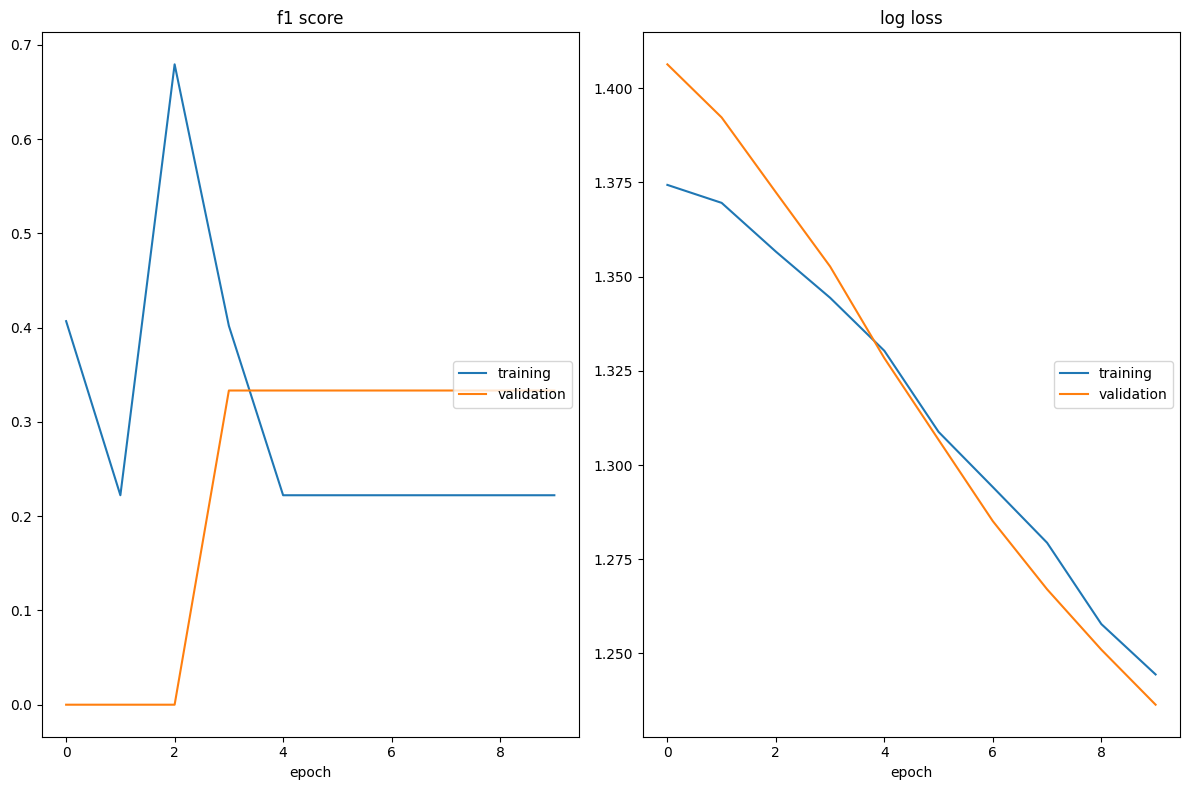

f1 score
	training         	 (min:    0.222, max:    0.679, cur:    0.222)
	validation       	 (min:    0.000, max:    0.333, cur:    0.333)
log loss
	training         	 (min:    1.244, max:    1.374, cur:    1.244)
	validation       	 (min:    1.236, max:    1.406, cur:    1.236)


AttributeError: Can't pickle local object 'load_tsn_model.<locals>.TSN'

In [8]:
train_tsn_model(num_classes=4, num_epochs=10,h5_file="tsn_teste.h5")

## I3D

In [7]:
class SegmentedVideoDatasetForI3D(Dataset):
    """
    Modified dataset class for I3D (Inflated 3D ConvNet)
    I3D requires clips of consecutive frames as input
    """
    def __init__(self, root_dir, label_path, transform=None, clip_length=16, 
                 clips_per_video=10, temporal_stride=2, test_mode=False, resize=(224, 224)):
        """
        Args:
            root_dir (str): Directory with video files
            label_path (str): Path to label file
            transform (callable): Transformations for frames
            clip_length (int): Number of frames in each clip
            clips_per_video (int): Number of clips to sample from each video
            temporal_stride (int): Sample every nth frame
            test_mode (bool): If True, use uniform sampling instead of random
        """
        self.root_dir = root_dir
        self.transform = transform
        self.clip_length = clip_length
        self.clips_per_video = clips_per_video
        self.temporal_stride = temporal_stride
        self.test_mode = test_mode
        self.resize = resize
        
        # Load video files and labels
        self.video_files = [f for f in os.listdir(root_dir) if f.endswith(('.mp4'))]
        self.label_dict = self._load_labels(label_path)
        
    def _load_labels(self, path):

        """Load labels from Excel file and map to video names"""
        df = pd.read_excel(path, header=0)
        
        df = df.drop(columns=["STUDENT","GROUP","TIME","SUTURES","INVESTIGATOR"])

        df = df.groupby("VIDEO").mean()
        
        # Create skill level labels
        df["TARGET_CLASS"] = df["GLOBA_RATING_SCORE"].apply(
            lambda x: "novice" if 8 <= x < 16 else
                    "intermediate" if 16 <= x < 24 else
                    "proficient" if 24 <= x < 32 else
                    "expert" if 32 <= x < 41 else None
        )
        # print(df.head())
            
        return dict(zip(df.index, df["TARGET_CLASS"]))

    def __len__(self):
        return len(self.video_files)
    
    def __getitem__(self, idx):
        video_file = self.video_files[idx]
        video_path = os.path.join(self.root_dir, video_file)
        
        # Get label
        video_name = os.path.splitext(video_file)[0]
        label = self.label_dict.get(video_name, None)
        label_tensor = torch.tensor(self._label_to_index(label)) if label else torch.tensor(-1)
        
        # Read all frames with specified stride
        all_frames = self._read_video_frames(video_path, self.temporal_stride)
        
        # If not enough frames, pad by repeating
        if len(all_frames) < self.clip_length:
            # Repeat the last frame
            padding = [all_frames[-1]] * (self.clip_length - len(all_frames))
            all_frames.extend(padding)
        
        # Sample clips
        clips = []
        if self.test_mode:
            # Uniform sampling for test mode
            if len(all_frames) <= self.clip_length:
                clips = [all_frames]
            else:
                stride = max(1, (len(all_frames) - self.clip_length) // (self.clips_per_video - 1))
                for i in range(self.clips_per_video):
                    start_idx = min(i * stride, len(all_frames) - self.clip_length)
                    clips.append(all_frames[start_idx:start_idx + self.clip_length])
        else:
            # Random sampling for training
            for _ in range(self.clips_per_video):
                if len(all_frames) <= self.clip_length:
                    clips.append(all_frames)
                else:
                    start_idx = random.randint(0, len(all_frames) - self.clip_length)
                    clips.append(all_frames[start_idx:start_idx + self.clip_length])
        
        # Transform clips
        transformed_clips = []
        for clip in clips:
            if self.transform:
                transformed_frames = []
                for frame in clip:
                    frame = self.transform(frame)
                    transformed_frames.append(frame)
                transformed_clips.append(torch.stack(transformed_frames))
            else:
                # Convert to tensor if no transform
                if not isinstance(clip[0], torch.Tensor):
                    clip = [torch.from_numpy(frame).permute(2, 0, 1) / 255.0 for frame in clip]
                transformed_clips.append(torch.stack(clip))
        
        # Stack all clips for this video
        video_data = torch.stack(transformed_clips)
        
        return video_data[0].permute(1, 0, 2, 3), label_tensor

    
    def _read_video_frames(self, video_path, stride=1):
        """Read frames from a video with specified stride"""
        frames = []
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                return frames
            
            frame_count = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Only keep frames based on stride
                if frame_count % stride == 0:
                    # Convert BGR to RGB
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    
                    # Resize
                    if frame.shape[0] != self.resize[0] or frame.shape[1] != self.resize[1]:
                        frame = cv2.resize(frame, (self.resize[1], self.resize[0]))
                    
                    frames.append(frame)
                
                frame_count += 1
            
            cap.release()
        except Exception as e:
            print(f"Error reading video {video_path}: {e}")
        
        return frames
    
    def _label_to_index(self, label):
        """Convert string label to numerical index"""
        label_map = {
            "novice": 0,
            "intermediate": 1,
            "proficient": 2,
            "expert": 3
        }
        return label_map.get(label, -1)
    
    def _compute_indices(self):
        """
        Compute indices for each video ahead of time to speed up training
        """
        self.video_indices = {}
        for video_file in self.video_files:
            video_path = os.path.join(self.root_dir, video_file)
            try:
                cap = cv2.VideoCapture(video_path)
                if not cap.isOpened():
                    print(f"Error: Could not open video {video_path}")
                    continue
                    
                total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                cap.release()
                
                # Store frame count for this video
                self.video_indices[video_file] = total_frames
            except Exception as e:
                print(f"Error reading video {video_path}: {e}")
    
    def _get_test_indices(self, total_frames):
        """
        Sample indices uniformly for testing
        """
        tick = total_frames / float(self.num_segments)
        indices = np.array([int(tick / 2.0 + tick * x) for x in range(self.num_segments)])
        indices = np.clip(indices, 0, total_frames - 1)
        return indices
    
    def _get_train_indices(self, total_frames):
        """
        Sample indices with random shifts for training
        """
        if total_frames <= self.num_segments:
            # If video is too short, repeat frames
            return np.array([i % total_frames for i in range(self.num_segments)])
            
        # Divide frames into segments
        segment_duration = total_frames / self.num_segments
        indices = []
        
        for i in range(self.num_segments):
            start = int(segment_duration * i)
            end = int(segment_duration * (i + 1))
            
            if self.random_shift:
                # Sample randomly within segment
                frame_index = random.randint(start, max(start, end - 1))
            else:
                # Sample center frame from segment
                frame_index = (start + end) // 2
            
            indices.append(frame_index)
        
        return np.array(indices)
    

### Treino

In [8]:
from i3d_model import I3D
BATCH_SIZE = 2
T = 15  # Number of frames per clip (can be changed to 64, etc.)

def train_i3d_model(num_classes=4, num_epochs=50, h5_file="i3d_model.pth"):

    frame_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    

    train_dataset = SegmentedVideoDatasetForI3D(
        root_dir="Package_train",
        label_path="OSATS.xlsx",
        transform=frame_transform,
        clip_length=T,
        test_mode=False,
        clips_per_video=1
    )
    
    val_dataset = SegmentedVideoDatasetForI3D(
        root_dir="Package_val",
        label_path="OSATS.xlsx",
        transform=frame_transform,
        clip_length=T,
        test_mode=True,
        clips_per_video=1
    )
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Load I3D model with improved head
    model = I3D(num_classes=num_classes, pretrained=True)
    model = model.to(device)

    # Print model summary
    print(summary(model, input_size=(BATCH_SIZE, 3, T, 224, 224)))

    # Optimization
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)

    liveloss = PlotLosses()

    for epoch in range(num_epochs):
        logs = {}

        # Training
        model.train()
        train_loss, all_preds, all_targets = 0.0, [], []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

        logs["log loss"] = train_loss / len(train_loader)
        logs["f1 score"] = f1_score(all_targets, all_preds, average="macro")

        # Validation
        model.eval()
        val_loss, all_preds, all_targets = 0.0, [], []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        logs["val_log loss"] = val_loss / len(val_loader)
        logs["val_f1 score"] = f1_score(all_targets, all_preds, average="macro")

        scheduler.step()
        liveloss.update(logs)
        liveloss.send()

    torch.save(model.state_dict(), h5_file)
    return model


In [ ]:
# train_i3d_model(num_classes=4, num_epochs=10,h5_file="tsn_teste.h5")
# Não consegui por a dar para já

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Unit3D: 2, Conv3d: 3, BatchNorm3d: 3, MaxPool3dSamePadding: 2, Unit3D: 2, Conv3d: 3, BatchNorm3d: 3, Unit3D: 2, Conv3d: 3, BatchNorm3d: 3, MaxPool3dSamePadding: 2, InceptionModule: 2, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, MaxPool3dSamePadding: 3, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, InceptionModule: 2, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, MaxPool3dSamePadding: 3, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, MaxPool3dSamePadding: 2, InceptionModule: 2, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, MaxPool3dSamePadding: 3, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, InceptionModule: 2, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, MaxPool3dSamePadding: 3, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, InceptionModule: 2, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, MaxPool3dSamePadding: 3, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, InceptionModule: 2, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, MaxPool3dSamePadding: 3, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, InceptionModule: 2, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, MaxPool3dSamePadding: 3, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, MaxPool3dSamePadding: 2, InceptionModule: 2, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, MaxPool3dSamePadding: 3, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, InceptionModule: 2, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, MaxPool3dSamePadding: 3, Unit3D: 3, Conv3d: 4, BatchNorm3d: 4, AvgPool3d: 2]

## Video_swirn

In [8]:
class SegmentedVideoDatasetForVideoSwin(Dataset):
    """
    Modified dataset for Video Swin Transformer
    Video Swin requires clips with specific dimensions and uniformly sampled frames
    """
    def __init__(self, root_dir, label_path, transform=None, num_segments=32, 
                 num_clips=1, test_mode=False, resize=(224, 224),ensure_last_clip_at_end=False):
        """
        Args:
            root_dir (str): Directory with video files
            label_path (str): Path to label file
            transform (callable): Transformations for frames
            num_segments (int): Number of frames to sample per clip
            num_clips (int): Number of clips to sample from each video
            test_mode (bool): If True, use uniform sampling instead of random
            ensure_last_clip_at_end (bool): Ensure the last clip is at the end of the video
        """
        self.root_dir = root_dir
        self.transform = transform
        self.num_segments = num_segments
        self.num_clips = num_clips
        self.test_mode = test_mode
        self.resize = resize
        self.random_shift = not test_mode
        self.ensure_last_clip_at_end = ensure_last_clip_at_end
        
        # Ensure root_dir exists
        if not os.path.exists(root_dir):
            raise FileNotFoundError(f"Directory not found: {root_dir}")
            
        # Load video files and labels
        self.video_files = [f for f in os.listdir(root_dir) if f.endswith(('.mp4'))]
        
        # Ensure there are video files in the directory
        if not self.video_files:
            raise RuntimeError(f"No video files found in {root_dir}")
            
        # Load labels safely
        try:
            self.label_dict = self._load_labels(label_path)
        except Exception as e:
            print(f"Error loading labels from {label_path}: {e}")
            self.label_dict = {}
    
    def __getitem__(self, idx):
        try:
            # print("here is the idx",idx)
            # print("here is the video files",self.video_files)
            video_file = self.video_files[idx]
            video_path = os.path.join(self.root_dir, video_file)
            
            # Get label
            video_name = os.path.splitext(video_file)[0]
            label = self.label_dict.get(video_name, None)
            # print("here is the label",label)
            
            # Handle missing labels gracefully
            if label is None:
                print(f"Warning: No label found for video {video_name}, using default class 0")
                label_tensor = torch.tensor(0)
            else:
                label_tensor = torch.tensor(self._label_to_index(label))
            
            # Read all frames with proper error handling
            all_frames = self._read_all_frames(video_path)
            
            if len(all_frames) == 0:
                # Handle empty video files by creating a dummy frame
                print(f"Warning: No frames found in video {video_path}, using dummy frames")
                dummy_frame = np.zeros((self.resize[0], self.resize[1], 3), dtype=np.uint8)
                all_frames = [dummy_frame] * self.num_segments
            
            # Sample frames for all clips
            sampled_clips = []
            
            for clip_idx in range(self.num_clips):
                if self.ensure_last_clip_at_end and clip_idx == self.num_clips - 1:
                    total_frames = len(all_frames)
                    if total_frames <= self.num_segments:
                        indices = np.array([min(i, total_frames - 1) for i in range(self.num_segments)])
                    else:
                        start_idx = total_frames - self.num_segments
                        indices = np.arange(start_idx, total_frames)
                else:
                    indices = self._sample_indices(len(all_frames))
                
                # Get frames at sampled indices
                frames = [all_frames[i] for i in indices]
                
                # Apply transform
                if self.transform:
                    transformed_frames = []
                    for frame in frames:
                        try:
                            frame = self.transform(frame)
                            transformed_frames.append(frame)
                        except Exception as e:
                            print(f"Transform error on frame: {e}")
                            # Create a fallback transformed frame as zeros
                            fallback = torch.zeros((3, self.resize[0], self.resize[1]))
                            transformed_frames.append(fallback)
                    frames = transformed_frames
                
                # Convert to tensor if needed
                if not isinstance(frames[0], torch.Tensor):
                    frames = [torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0 for frame in frames]
                
                # Stack frames for this clip
                clip_tensor = torch.stack(frames)
                sampled_clips.append(clip_tensor)
            
            # Stack all clips
            video_tensor = torch.stack(sampled_clips)
            
            # Rearrange to expected format [num_clips, C, T, H, W]
            video_tensor = video_tensor.permute(0, 2, 1, 3, 4)
            
            return video_tensor, label_tensor
            
        except Exception as e:
            print(f"Error processing item {idx}, video file {self.video_files[idx] if idx < len(self.video_files) else 'unknown'}: {e}")
            # Return a dummy tensor as fallback
            dummy_video = torch.zeros((self.num_clips, 3, self.num_segments, self.resize[0], self.resize[1]))
            dummy_label = torch.tensor(0)
            return dummy_video, dummy_label
    
    def _sample_indices(self, total_frames):
        """Sample indices with proper handling for short videos"""
        if self.test_mode:
            # Uniform sampling for test mode
            if total_frames <= self.num_segments:
                # Not enough frames, duplicate some
                indices = np.array([min(i, total_frames - 1) for i in range(self.num_segments)])
            else:
                # Sample uniformly
                indices = np.linspace(0, total_frames - 1, self.num_segments, dtype=int)
        else:
            # Random sampling for training
            if total_frames <= self.num_segments:
                # Not enough frames, duplicate some
                indices = np.array([min(i, total_frames - 1) for i in range(self.num_segments)])
            else:
                # Random sequential sampling
                max_start = total_frames - self.num_segments
                start_idx = random.randint(0, max(0, max_start))
                indices = np.arange(start_idx, min(start_idx + self.num_segments, total_frames))
                
                # If we don't have enough frames, pad with the last frame
                if len(indices) < self.num_segments:
                    padding = np.array([indices[-1]] * (self.num_segments - len(indices)))
                    indices = np.concatenate([indices, padding])
        
        return indices
    
    def _read_all_frames(self, video_path):
        """Read all frames from a video with proper error handling"""
        frames = []
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Warning: Could not open video {video_path}")
                return frames
            
            frame_count = 0
            max_frames = 10000  # Safety limit to prevent memory issues
            
            while frame_count < max_frames:
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Convert BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Resize
                if frame.shape[0] != self.resize[0] or frame.shape[1] != self.resize[1]:
                    frame = cv2.resize(frame, (self.resize[1], self.resize[0]))
                
                frames.append(frame)
                frame_count += 1
            
            cap.release()
            
            if frame_count == 0:
                print(f"Warning: No frames read from {video_path}")
                
        except Exception as e:
            print(f"Error reading video {video_path}: {e}")
        
        return frames

    def _load_labels(self, path):
        """Load labels from Excel file and map to video names"""
        if not os.path.exists(path):
            print(f"Warning: Label file not found: {path}")
            return {}
            
        try:
            df = pd.read_excel(path, header=0)
            
            # Handle potential missing columns gracefully
            required_columns = ["VIDEO", "GLOBA_RATING_SCORE"]
            for col in required_columns:
                if col not in df.columns:
                    print(f"Warning: Required column '{col}' not found in label file")
                    return {}
            
            drop_columns = ["STUDENT", "GROUP", "TIME", "SUTURES", "INVESTIGATOR"]
            # Only drop columns that exist
            cols_to_drop = [col for col in drop_columns if col in df.columns]
            if cols_to_drop:
                df = df.drop(columns=cols_to_drop)
            
            # Group by video name and calculate mean
            df = df.groupby("VIDEO").mean()
            
            # Create skill level labels with bounds checking
            df["TARGET_CLASS"] = df["GLOBA_RATING_SCORE"].apply(
                lambda x: "novice" if 8 <= x < 16 else
                        "intermediate" if 16 <= x < 24 else
                        "proficient" if 24 <= x < 32 else
                        "expert" if 32 <= x <= 40 else "unknown"
            )
            
            return dict(zip(df.index, df["TARGET_CLASS"]))
        except Exception as e:
            print(f"Error processing label file {path}: {e}")
            return {}
    
    def __len__(self):
        return len(self.video_files)
    
    def _label_to_index(self, label):
        """Convert string label to numerical index"""
        label_map = {
            "novice": 0,
            "intermediate": 1,
            "proficient": 2,
            "expert": 3,
            "unknown": -1
        }
        return label_map.get(label, -1)

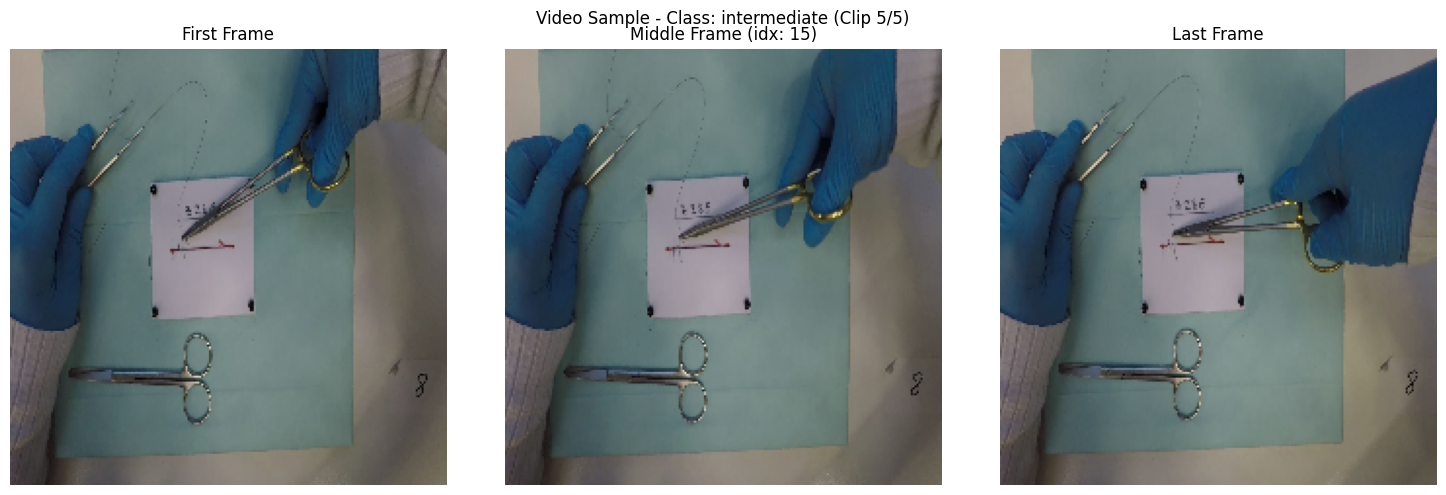

In [ ]:
def visualize_sample_frames(dataset, idx=0, clip_idx=None):
    """
    Helper function to visualize sampled frames from a dataset.
    
    Args:
        dataset: the video dataset
        idx: index of the video sample
        clip_idx: which clip to visualize (default is last if None)
    """
    import matplotlib.pyplot as plt
    
    video_tensor, label = dataset[idx]  # shape: [num_clips, C, T, H, W]

    # Select which clip to visualize
    num_clips = video_tensor.size(0)
    if clip_idx is None:
        clip_idx = num_clips - 1  # Default: show the last clip

    video_tensor = video_tensor[clip_idx]  # shape: [C, T, H, W]
    
    # Rearrange to [T, H, W, C]
    frames = video_tensor.permute(1, 2, 3, 0)
    
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 1, 3)
    frames = frames * std + mean
    frames = torch.clamp(frames, 0, 1).numpy()

    # Plot first, middle, and last frames
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(frames[0])
    axes[0].set_title("First Frame")
    axes[0].axis("off")
    
    mid_idx = len(frames) // 2
    axes[1].imshow(frames[mid_idx])
    axes[1].set_title(f"Middle Frame (idx: {mid_idx})")
    axes[1].axis("off")
    
    axes[2].imshow(frames[-1])
    axes[2].set_title("Last Frame")
    axes[2].axis("off")

    class_names = ["novice", "intermediate", "proficient", "expert"]
    label_name = class_names[label.item()] if 0 <= label.item() < len(class_names) else "unknown"

    plt.suptitle(f"Video Sample - Class: {label_name} (Clip {clip_idx + 1}/{num_clips})")
    plt.tight_layout()
    plt.show()



transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Dataset that ensures final result (end frames) are always included
dataset_with_end = SegmentedVideoDatasetForVideoSwin(
    root_dir="Package_val",
    label_path="OSATS.xlsx",
    transform=transform,
    num_segments=30,
    num_clips=5,
    ensure_last_clip_at_end=True,
)

visualize_sample_frames(dataset_with_end, idx=0, clip_idx=4)


In [72]:
from torchvision.utils import save_image
import traceback


def dump_video_clips_as_images(dataset, idx=0, output_dir="output_dump"):
    """
    Dumps all clips of a video sample into folders with each frame saved as an image.

    Args:
        dataset: The dataset object
        idx (int): Index of the sample to dump
        output_dir (str): Base directory where the clips will be saved
    """
    import shutil

    # Clean output directory
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    # Get sample
    video_tensor, label = dataset[idx]  # [num_clips, C, T, H, W]
    num_clips = video_tensor.shape[0]
    num_segments = video_tensor.shape[2]

    print(f"Saving {num_clips} clips with {num_segments} frames each...")

    for clip_idx in range(num_clips):
        clip_tensor = video_tensor[clip_idx]  # shape: [C, T, H, W]
        clip_dir = os.path.join(output_dir, f"clip_{clip_idx}")
        os.makedirs(clip_dir, exist_ok=True)

        # Denormalize frames
        clip_tensor = clip_tensor.permute(1, 0, 2, 3)  # [T, C, H, W]
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        denorm_clip = clip_tensor * std + mean
        denorm_clip = torch.clamp(denorm_clip, 0, 1)

        # Save each frame as an image
        for frame_idx, frame_tensor in enumerate(denorm_clip):
            frame_path = os.path.join(clip_dir, f"frame_{frame_idx:03d}.png")
            save_image(frame_tensor, frame_path)

    print(f"Clips dumped to: {os.path.abspath(output_dir)}")

dump_video_clips_as_images(dataset_with_end, idx=0, output_dir="dump_sample_0")


KeyboardInterrupt: 

In [85]:
from sklearn.metrics import f1_score
from video_swin_model import load_tsn_video_swin
import traceback
BATCH_SIZE = 1  # Video Swin is heavier on memory

def train_video_swin_model(num_classes=4, num_epochs=50, h5_file="video_swin_model.pth"):
    try:
        print(f"Using device: {device}")
        
        # Define transforms
        common_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])

        # Verify paths exist
        train_dir = "Package_train"
        val_dir = "Package_val"
        label_path = "OSATS.xlsx"
        
        if not os.path.exists(train_dir):
            raise FileNotFoundError(f"Training directory not found: {train_dir}")
        if not os.path.exists(val_dir):
            raise FileNotFoundError(f"Validation directory not found: {val_dir}")
        if not os.path.exists(label_path):
            raise FileNotFoundError(f"Label file not found: {label_path}")

        # Datasets with keep_the_end parameter
        print("Creating training dataset...")
        train_dataset = SegmentedVideoDatasetForVideoSwin(
            root_dir=train_dir,
            label_path=label_path,
            transform=common_transform,
            num_segments=32,
            test_mode=False,
            num_clips=2,
            ensure_last_clip_at_end=True,
        )

        print("Creating validation dataset...")
        val_dataset = SegmentedVideoDatasetForVideoSwin(
            root_dir=val_dir,
            label_path=label_path,
            transform=common_transform,
            num_segments=32,
            test_mode=True,
            num_clips=2,
            ensure_last_clip_at_end=True,
        )

        print(f"Training on {len(train_dataset)} videos, validating on {len(val_dataset)} videos")

        # Use fewer workers to avoid multiprocessing issues
        train_loader = DataLoader(
            train_dataset, 
            batch_size=BATCH_SIZE, 
            shuffle=True, 
            num_workers=0,  # Set to 0 to diagnose errors
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=BATCH_SIZE, 
            shuffle=False, 
            num_workers=0,  # Set to 0 to diagnose errors
            pin_memory=True
        )

        # Load model
        print("Loading model...")
        model = load_tsn_video_swin(num_classes=num_classes, pretrained=True, model_name='swin3d_t')
        model = model.to(device)

        # Model summary - Using a properly formatted dummy input
        try:
            print("Generating model summary...")
            dummy_input = torch.randn(BATCH_SIZE, 3, 32, 224, 224).to(device)  # [B, C, T, H, W]
            print(summary(model, input_data=dummy_input))
        except Exception as e:
            print(f"Error generating model summary: {e}")
            print("Continuing without summary...")

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)

        liveloss = PlotLosses()

        model_filename = h5_file.replace('.pth', '_random.pth')
        
        print(f"Model will be saved as: {model_filename}")
        print("Starting training...")
        best_val_f1 = 0.0
        
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            logs = {}

            # Training
            model.train()
            train_loss = 0.0
            all_preds, all_targets = [], []
            
            for batch_idx, batch in enumerate(train_loader):
                inputs = batch[0]
                targets = batch[1]  # adjust if there are more fields
                try:
                    print(f"Training batch {batch_idx+1}/{len(train_loader)}", end='\r')
                    
                    # Skip batches with invalid targets
                    if torch.any(targets < 0):
                        print(f"Skipping batch with invalid targets: {targets}")
                        continue
                    
                    # Debug input shapes
                    print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
                    
                    # inputs shape from dataloader: [B, num_clips, C, T, H, W]
                    # Need to reshape to [B, C, T, H, W] for the model
                    inputs, targets = inputs.to(device), targets.to(device)
                    

                    if inputs.dim() == 6:
                        B, num_clips, C, T, H, W = inputs.shape
                        inputs = inputs.view(B * num_clips, C, T, H, W)
                        targets = targets.repeat_interleave(num_clips)
                    
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    _, preds = outputs.max(1)
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
                except Exception as e:
                    print(f"\nError in training batch {batch_idx}: {e}")
                    print(traceback.format_exc())
                    print("Skipping this batch and continuing...")
                    continue

            # Calculate metrics if we have predictions
            if len(all_preds) > 0 and len(all_targets) > 0:
                train_f1 = f1_score(all_targets, all_preds, average='macro')
                logs['log loss'] = train_loss / len(train_loader)
                logs['f1 score'] = train_f1
                print(f"Train Loss: {logs['log loss']:.4f}, F1 Score: {train_f1:.4f}")
            else:
                print("Warning: No valid predictions in training set")

            # Validation
            model.eval()
            val_loss = 0.0
            all_preds, all_targets = [], []

            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(val_loader):
                    try:
                        print(f"Validation batch {batch_idx+1}/{len(val_loader)}", end='\r')
                        
                        # Skip batches with invalid targets
                        if torch.any(targets < 0):
                            print(f"Skipping batch with invalid targets: {targets}")
                            continue
                            
                        inputs, targets = inputs.to(device), targets.to(device)
                        
                        # If inputs has shape [B, 1, C, T, H, W], squeeze out the num_clips dimension
                        print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
                        if inputs.dim() == 6:
                            # Merge num_clips into batch dimension or handle accordingly
                            B, num_clips, C, T, H, W = inputs.shape
                            inputs = inputs.view(B * num_clips, C, T, H, W)
                            targets = targets.repeat_interleave(num_clips)

                        print(f"After Input shape: {inputs.shape}, Target shape: {targets.shape}")
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)

                        val_loss += loss.item()
                        _, preds = outputs.max(1)
                        all_preds.extend(preds.cpu().numpy())
                        all_targets.extend(targets.cpu().numpy())
                    except Exception as e:
                        print(f"\nError in validation batch {batch_idx}: {e}")
                        print("Skipping this batch and continuing...")
                        continue

            # Calculate metrics if we have predictions
            if len(all_preds) > 0 and len(all_targets) > 0:
                val_f1 = f1_score(all_targets, all_preds, average='macro')
                logs['val_log loss'] = val_loss / len(val_loader)
                logs['val_f1 score'] = val_f1
                print(f"Val Loss: {logs['val_log loss']:.4f}, F1 Score: {val_f1:.4f}")
                
                # Save best model
                if val_f1 > best_val_f1:
                    best_val_f1 = val_f1
                    print(f"Saving best model with F1 score: {val_f1:.4f}")
                    torch.save(model.state_dict(), model_filename)
            else:
                print("Warning: No valid predictions in validation set")

            scheduler.step()
            
            try:
                liveloss.update(logs)
                liveloss.send()
            except Exception as e:
                print(f"Error updating live loss plot: {e}")

        print(f"Training completed. Best validation F1 score: {best_val_f1:.4f}")
        print(f"Best model saved as: {model_filename}")
        return model
        
    except Exception as e:
        print(f"Error in training function: {e}")
        return None

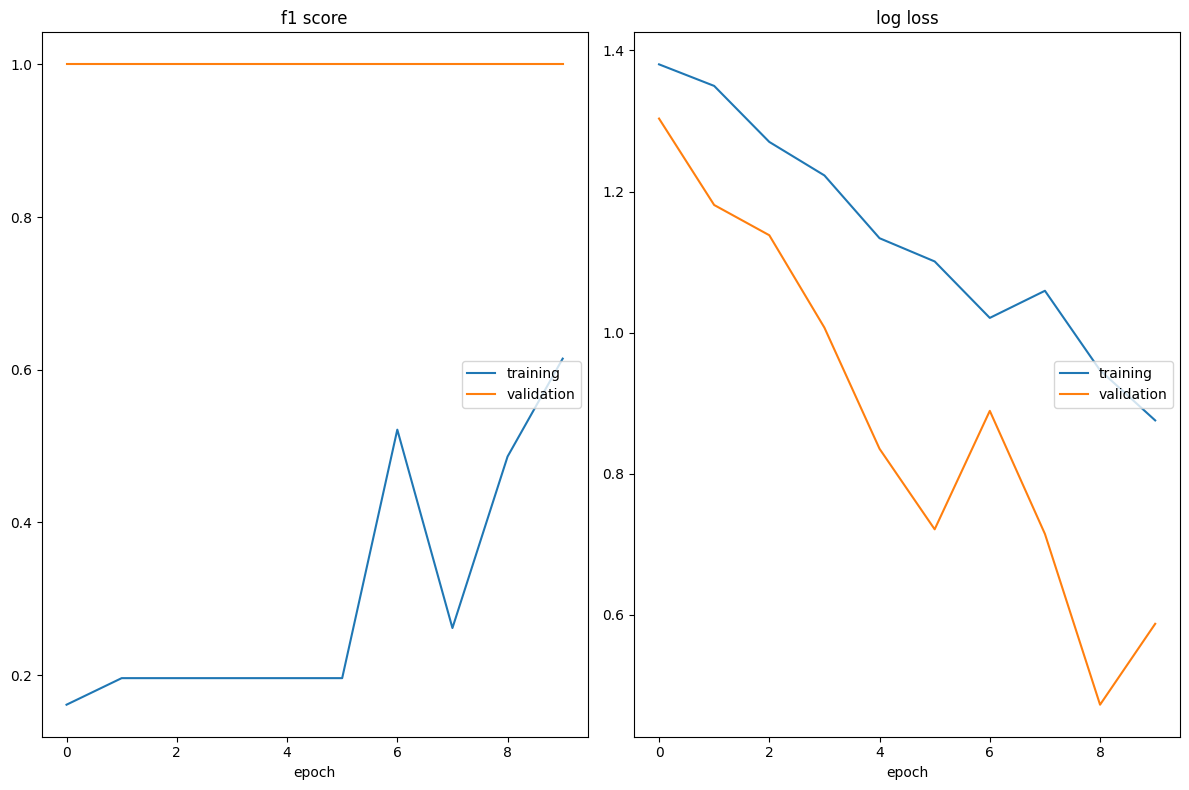

f1 score
	training         	 (min:    0.161, max:    0.615, cur:    0.615)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
log loss
	training         	 (min:    0.876, max:    1.380, cur:    0.876)
	validation       	 (min:    0.472, max:    1.303, cur:    0.587)
Training completed. Best validation F1 score: 1.0000
Best model saved as: surgical_skill_model_video_swin_random.pth


In [86]:
model_with_end = train_video_swin_model(
    num_classes=4,
    num_epochs=10,
    h5_file="surgical_skill_model_video_swin.pth",
)